In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import scipy as sp
import scipy.stats as stats
%matplotlib inline

In [2]:
# pricing parameters

# economics
K = 100.0
T = 2.

# market data
Vol = 0.30
R = 0.05
S0 = 90.

In [3]:
# black scholes analytic solutions

def d1(s, k, r, vol, t):
    return (sp.log(s/k)+(r+(0.5*vol*vol))*t)/(vol*sp.sqrt(t))
def d2(s, k, r, vol, t):
    return (sp.log(s/k)+(r-(0.5*vol*vol))*t)/(vol*sp.sqrt(t))
def bs_call(s, k, r, vol, t):
    return s*stats.norm.cdf(d1(s, k, r, vol, t)) - k*sp.exp(-1.*r*t)*stats.norm.cdf(d2(s, k, r, vol, t))
def bs_put(s, k, r, vol, t):
    return -1.*s*stats.norm.cdf(-1.*d1(s, k, r, vol, t)) + k*sp.exp(-1.*r*t)*stats.norm.cdf(-1.*d2(s, k, r, vol, t))
def bs_digital_call(s, k, r, vol, t):
    return sp.exp(-1.*r*t)*stats.norm.cdf(d2(s, k, r, vol, t))
def bs_digital_put(s, k, r, vol, t):
    return sp.exp(-1.*r*t)*(1.-stats.norm.cdf(d2(s, k, r, vol, t)))
def zcb(r ,t):
    return sp.exp(-1.*r*t)

In [4]:
# payoff implementations

class call_payoff:
    def __init__(self, k):
        self.k = k
    def calc(self, spots):
        return np.maximum(spots-self.k, 0.)

class put_payoff:
    def __init__(self, k):
        self.k = k
    def calc(self, spots):
        return np.maximum(self.k-spots, 0.)

class digital_call_payoff:
    def __init__(self, k):
        self.k = k
    def calc(self, spots):
        return 1. * (spots > self.k)

In [26]:
# tree product implementations

class european_tree_product:
    def __init__(self, final_time, payoff):
        self.final_time = final_time
        self.payoff = payoff
    def final_time(self):
        return self.final_time
    def final_payoff(self, spot):
        return self.payoff.calc(spot)
    def pre_final_value(self, spot, discounted_future_value):
        return discounted_future_value
    
class american_tree_product:
    def __init__(self, final_time, payoff):
        self.final_time = final_time
        self.payoff = payoff
    def final_time(self):
        return self.final_time
    def final_payoff(self, spot):
        return self.payoff.calc(spot)
    def pre_final_value(self, spot, discounted_future_value):
        return np.maximum(self.payoff.calc(spot), discounted_future_value)

In [27]:
# binomial tree

class simple_binomial_tree:
    
    def __init__(self, s0, r, vol, num_of_steps, time):
        self.spot_tree = []
        self.num_of_steps = num_of_steps
        log_spot = sp.log(s0)
        dt = time/num_of_steps
        sd = vol*sp.sqrt(dt)
        for step in range(num_of_steps+1):
            t = step*dt
            moved_log_spot = log_spot+(r*t)
            moved_log_spot -= 0.5*vol*vol*t
            self.spot_tree.append([sp.exp(moved_log_spot+(w*sd)) for w in range(-step, step+1, 2)])
        self.df = zcb(r, time/num_of_steps)
        #print "Spots"
        #print self.spot_tree
        
    def price(self, product):
        option_tree = [None]*(self.num_of_steps+1)
        option_tree[self.num_of_steps] = [product.final_payoff(s) for s in self.spot_tree[self.num_of_steps]]
        for step in range(self.num_of_steps-1, -1, -1):
            option_tree[step] = [None]*(step+1)
            for i in range(step+1):
                future_discounted_value = 0.5*self.df*(option_tree[step+1][i]+option_tree[step+1][i+1])
                option_tree[step][i] = product.pre_final_value(self.spot_tree[step][i], future_discounted_value)
        #print "Options"
        #print option_tree
        return option_tree[0][0]

In [35]:
# Test pricing

no_steps = 200

cp = put_payoff(K)

etp = european_tree_product(T, cp)

sbt = simple_binomial_tree(S0, R, Vol, no_steps, T)
sbt2 = simple_binomial_tree(S0, R, Vol, no_steps+1, T)

euro_tree_price1 = sbt.price(etp)
euro_tree_price2 = sbt2.price(etp)
euro_tree_price = (euro_tree_price1 + euro_tree_price2)/2.

atp = american_tree_product(T, cp)
american_tree_price1 = sbt.price(atp)
american_tree_price2 = sbt2.price(atp)
american_tree_price = (american_tree_price1+american_tree_price2)/2.

bs_option_price = bs_put(S0, K, R, Vol, T)

print "Theoretical BS price = {}".format(bs_option_price)
print "Euro tree price = {}".format(euro_tree_price)
print "American tree price = {}".format(american_tree_price)


Theoretical BS price = 15.4033336951
Euro tree price = 15.4075611106
American tree price = 17.1888988946


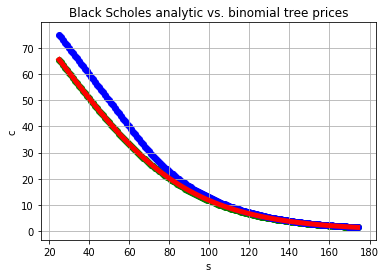

In [36]:
spots = np.arange(25., 175., 1.)

analytic_price = bs_put(spots, K, R, Vol, T)

sbts = simple_binomial_tree(spots, R, Vol, no_steps, T)
euro_tree_prices = sbts.price(etp)
american_tree_prices = sbts.price(atp)

line, = plt.plot(spots, analytic_price, 'r-')
plt.setp(line, color='r', linewidth=5.0)

plt.scatter(spots, euro_tree_prices, color=['green'])
plt.scatter(spots, american_tree_prices, color=['blue'])

plt.xlabel('s')
plt.ylabel('c')
plt.title('Black Scholes analytic vs. binomial tree prices')
plt.grid(True)
plt.show()